In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Data Collection

In [2]:
df=pd.read_csv('/kaggle/input/people-wikipedia-data/people_wiki.csv')

In [3]:
df.head()

URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  
0  digby morrell born 10 october 1979 is a former...  
1  alfred j lewy aka sandy lewy graduated from un...  
2  harpdog brown is a singer and harmonica player...  
3  franz rottensteiner born in waidmannsfeld lowe...  
4  henry krvits born 30 december 1974 in tallinn ...

In [4]:
df.shape

(42786, 3)

In [5]:
print(len(list(df['name'].unique())))

42785


# Data Preprocessing

In [6]:
import re
import nltk
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()

    # Remove emails
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization and stopword removal + stemming
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

df["data_str"] = df.text.apply(lambda row: preprocess(row) )


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# clustering & Visualization

## Kmeans Clustering

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [8]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3), max_features=2**10)
pca = PCA(n_components=2)  
text_to_vector = vectorizer.fit_transform(df.data_str.values)
X_pca = pca.fit_transform(text_to_vector.toarray())

In [9]:
inertia = []  
k_range = range(10,1000,10)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)  


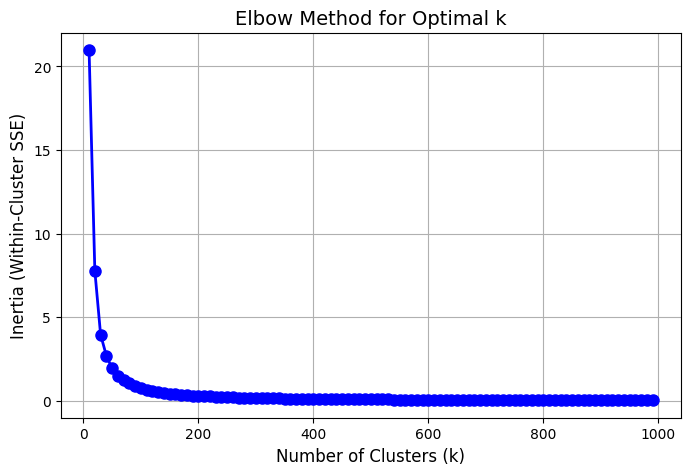

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster SSE)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True)
plt.show()


In [13]:
# with pca
kmeans = KMeans(n_clusters=150, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)
score = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {score:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5168


In [28]:
# without PCA
kmeans = KMeans(n_clusters=150, random_state=42)
cluster_labels = kmeans.fit_predict(text_to_vector.toarray())
score = silhouette_score(text_to_vector.toarray(), cluster_labels)
print(f"Silhouette Score: {score:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.2245


In [15]:
t_sne = TSNE(perplexity=100, random_state=42)
X_embedded=t_sne.fit_transform(text_to_vector.toarray())

<ipython-input-26-fa8874e9dbee>:3: UserWarning: 
The palette list has fewer values (20) than needed (150) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels,palette=palette, legend=False)


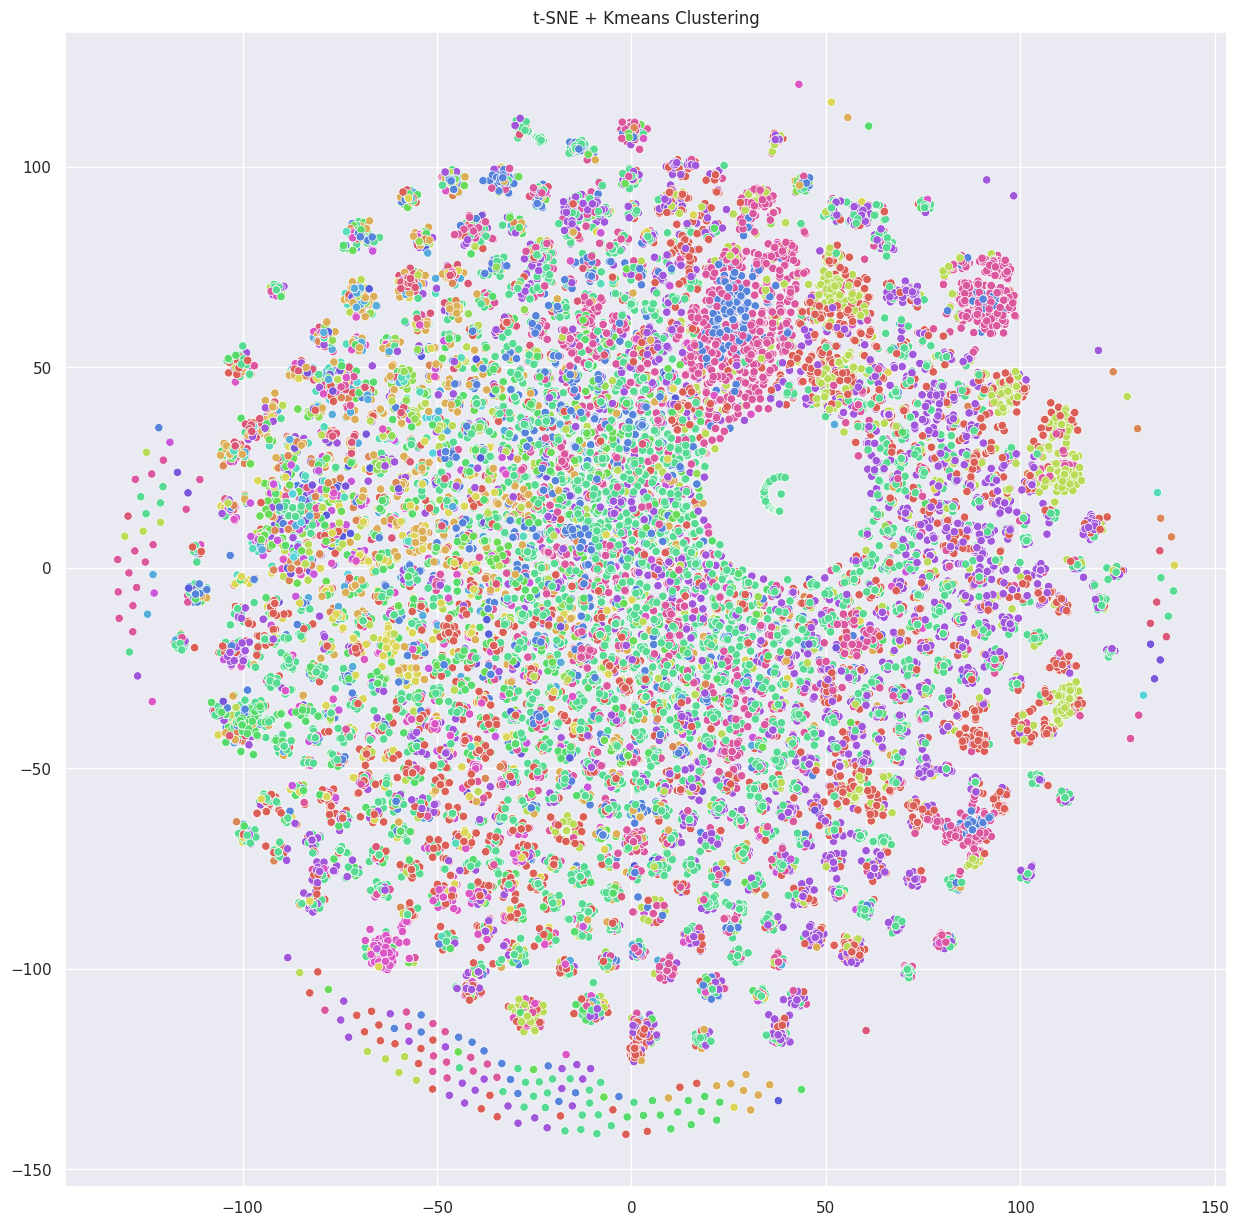

In [26]:
palette = sns.color_palette("hls", 20)
sns.set(rc={'figure.figsize': (15, 15)})
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels,palette=palette, legend=False)
title = f"t-SNE + Kmeans Clustering"
plt.title(title)
plt.show()

## Hierarchical  clustering

In [18]:
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=150, affinity='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_pca)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [19]:
score = silhouette_score(X_pca, agg_labels)
print("Silhouette Score:", score)

Silhouette Score: 0.45655031007055863


<ipython-input-23-ab66c3dffcd1>:3: UserWarning: 
The palette list has fewer values (20) than needed (150) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=agg_labels, palette=palette, legend=False)


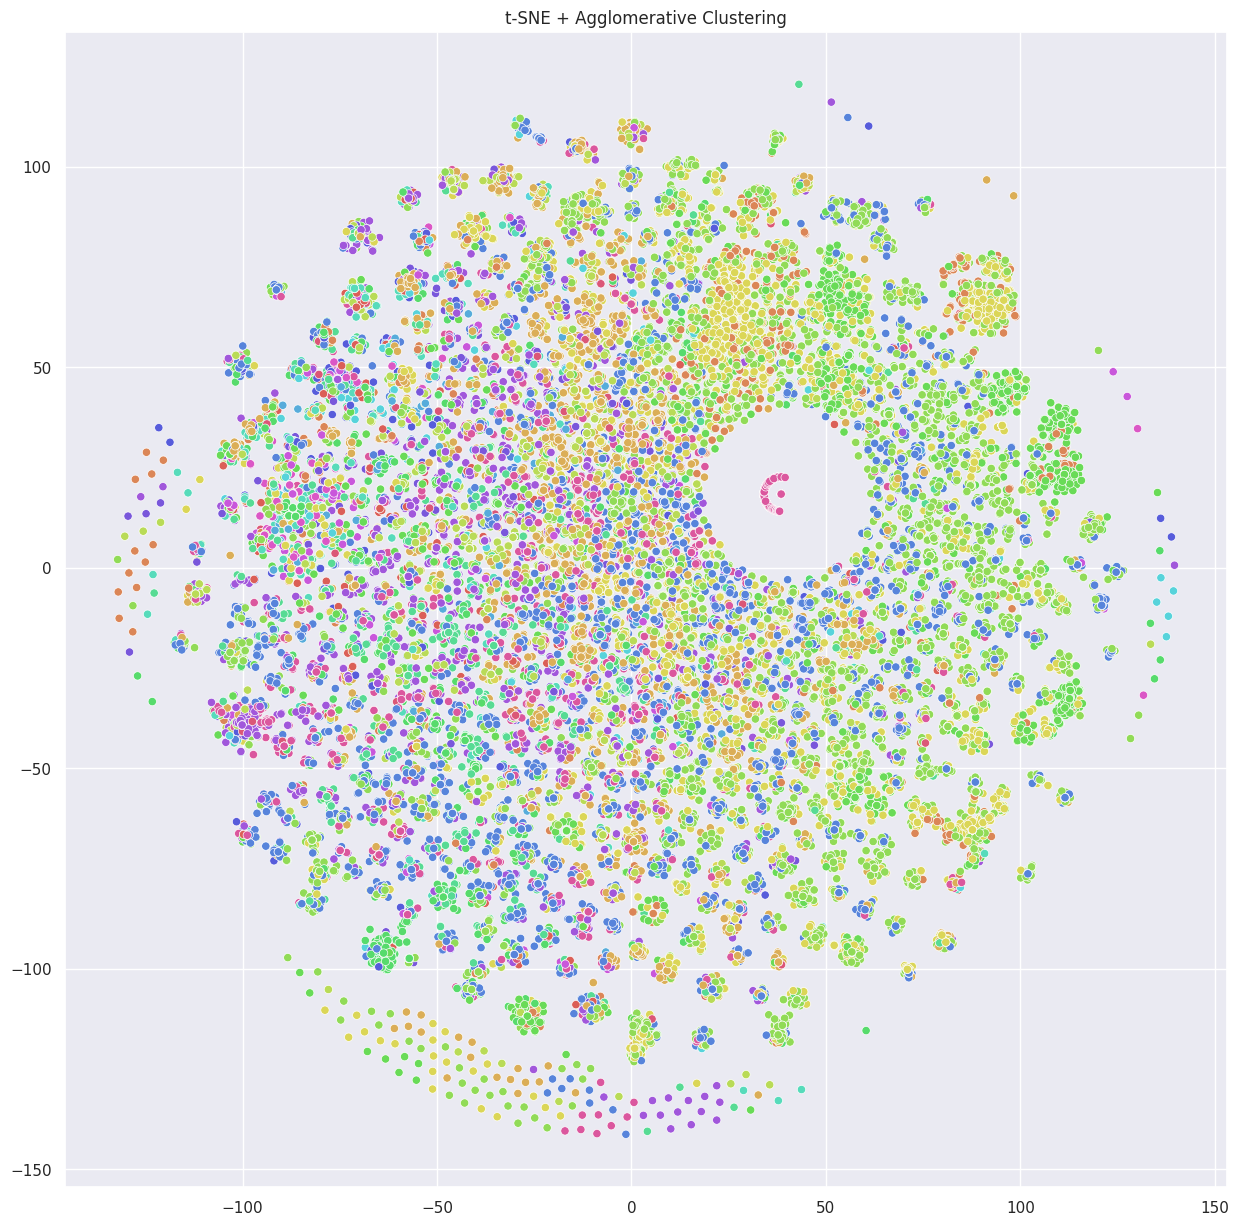

In [23]:
sns.set(rc={'figure.figsize': (15, 15)})
palette = sns.color_palette("hls", 20)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=agg_labels, palette=palette, legend=False)
title = f"t-SNE + Agglomerative Clustering"
plt.title(title)
plt.show()

## GaussianMixture Model

In [21]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=150, random_state=42)
gmm.fit(X_pca)



GaussianMixture(n_components=150, random_state=42)

In [24]:
y_gmm_pred = gmm.predict(X_pca)

In [25]:
print("Log Likelihood:", gmm.score(X_pca))

Log Likelihood: 8.268896551294642


<ipython-input-27-4eb863100636>:3: UserWarning: 
The palette list has fewer values (20) than needed (148) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_gmm_pred, palette=palette, legend=False)


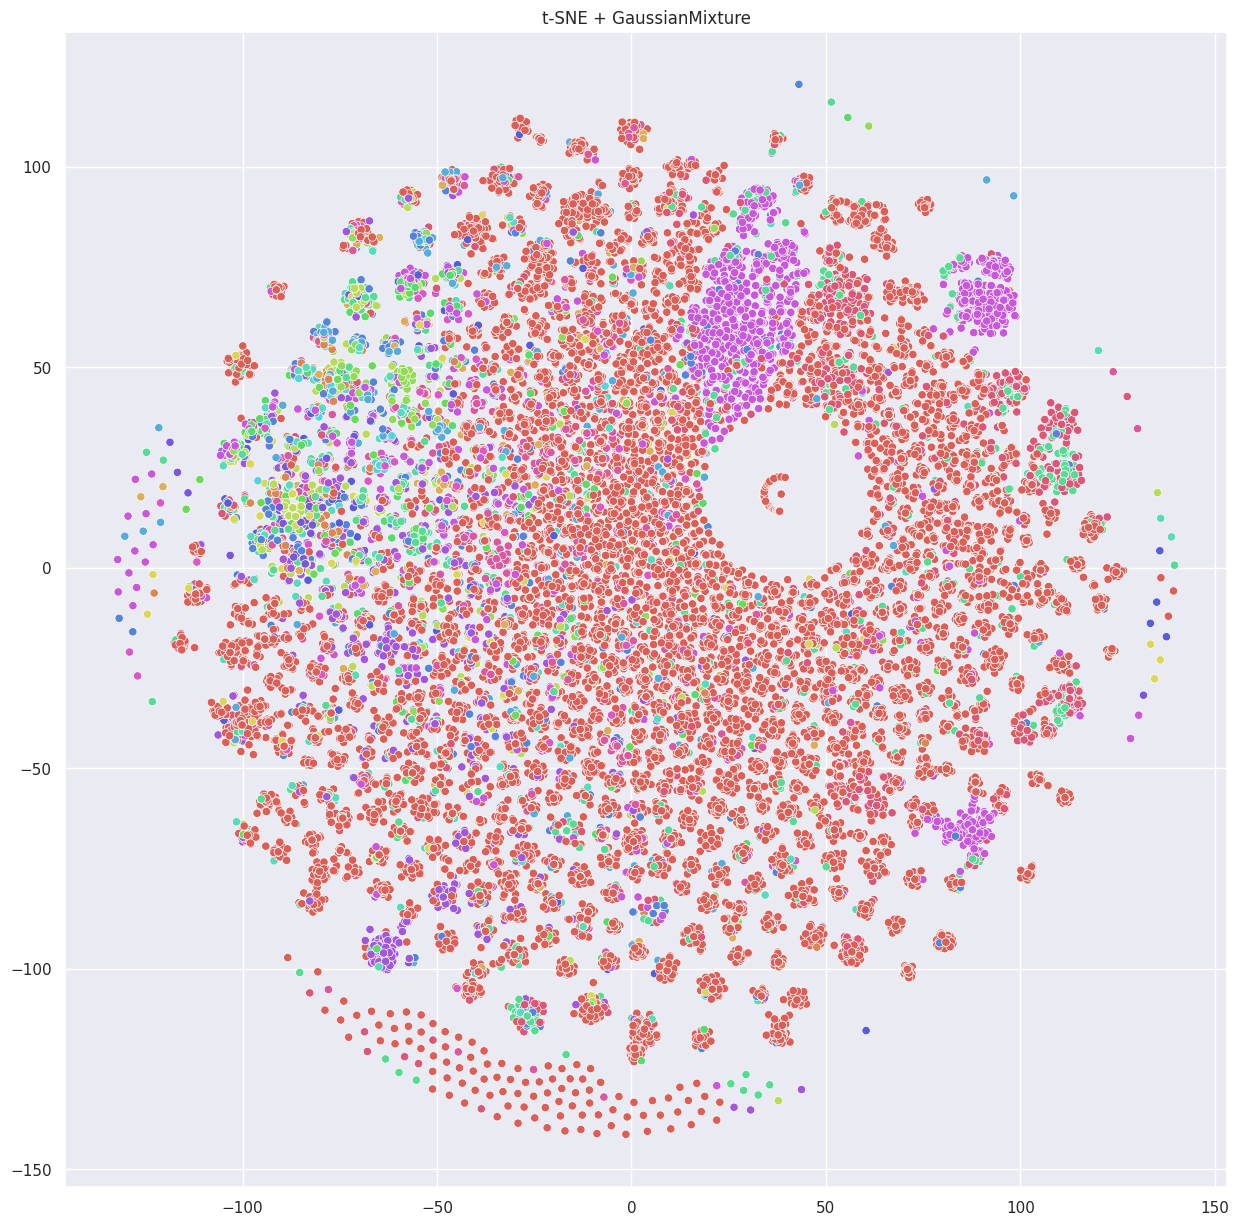

In [27]:
sns.set(rc={'figure.figsize': (15, 15)})
palette = sns.color_palette("hls", 20)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_gmm_pred, palette=palette, legend=False)
title = f"t-SNE + GaussianMixture"
plt.title(title)
plt.show()